# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
"""
you will be forecasting real estate prices of various zip codes 

What are the top 5 best zip codes for us to invest in?

Should your recommendation be focused on profit margins only? 
What about risk? 
What sort of time horizon are you predicting against? 
Your recommendation will need to detail your rationale and answer any sort of lingering questions like these 
    in order to demonstrate how you define "best".

Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), 
    you need to start with a definition of "best investment". 
    Consider additional metrics like risk vs. profitability, or ROI yield.


"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

#from matplotlib.pylab import rcParams

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#pd.set_option('display.max_columns', None)  
zillow = pd.read_csv('zillow_data.csv')
zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [5]:
all_zipcodes = melt_data(zillow)

In [6]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [7]:
all_zipcodes.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [8]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
10,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
13,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
47,62040,11230,New York,NY,New York,Kings,48,1996-04-01,230100.0
49,62020,11209,New York,NY,New York,Kings,50,1996-04-01,255700.0
53,62023,11212,New York,NY,New York,Kings,54,1996-04-01,125000.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [9]:
"""
test_dict = {}

for zipcode in kings['Zipcode'].unique(): 
    all_zips = kings[kings['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    brooklyn_zips[zipcode] = all_zips
"""
test_dict = {}

for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips

In [10]:
test_dict

{11226: Month
 1996-04-01    162000.0
 1996-05-01    162300.0
 1996-06-01    162600.0
 1996-07-01    163000.0
 1996-08-01    163400.0
                 ...   
 2017-12-01    887800.0
 2018-01-01    890500.0
 2018-02-01    901700.0
 2018-03-01    930700.0
 2018-04-01    963200.0
 Freq: MS, Name: 11226, Length: 265, dtype: float64,
 11235: Month
 1996-04-01    190500.0
 1996-05-01    191000.0
 1996-06-01    191500.0
 1996-07-01    192000.0
 1996-08-01    192500.0
                 ...   
 2017-12-01    799700.0
 2018-01-01    806600.0
 2018-02-01    810600.0
 2018-03-01    813400.0
 2018-04-01    816200.0
 Freq: MS, Name: 11235, Length: 265, dtype: float64,
 11230: Month
 1996-04-01     230100.0
 1996-05-01     230800.0
 1996-06-01     231500.0
 1996-07-01     232100.0
 1996-08-01     232800.0
                 ...    
 2017-12-01    1102400.0
 2018-01-01    1120200.0
 2018-02-01    1141600.0
 2018-03-01    1170000.0
 2018-04-01    1195400.0
 Freq: MS, Name: 11230, Length: 265, dtype: float

In [11]:
zip_df = pd.concat(test_dict, axis=1)

In [12]:
len(zip_df)

265

In [13]:
zip_df.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
1996-04-01,162000.0,190500.0,230100.0,255700.0,125000.0,191000.0,133700.0,183900.0,172300.0,225700.0,...,149000.0,188500.0,146100.0,187300.0,158000.0,149200.0,219300.0,NaN,NaN,NaN
1996-05-01,162300.0,191000.0,230800.0,256600.0,125000.0,191200.0,133700.0,184200.0,172100.0,227500.0,...,149200.0,188700.0,146600.0,187300.0,157300.0,148400.0,219600.0,NaN,NaN,NaN
1996-06-01,162600.0,191500.0,231500.0,257300.0,125000.0,191500.0,133700.0,184500.0,171900.0,229400.0,...,149400.0,188800.0,147200.0,187200.0,156700.0,147500.0,219900.0,NaN,NaN,NaN
1996-07-01,163000.0,192000.0,232100.0,258100.0,125000.0,191900.0,133700.0,184800.0,171600.0,231600.0,...,149600.0,189000.0,147700.0,187100.0,156100.0,146600.0,220200.0,NaN,NaN,NaN
1996-08-01,163400.0,192500.0,232800.0,258900.0,125100.0,192100.0,133900.0,185000.0,171400.0,234100.0,...,149700.0,189400.0,148400.0,187000.0,155600.0,146000.0,220600.0,NaN,NaN,NaN


In [14]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [15]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [16]:
zip_df.isna().sum()

11226     0
11235     0
11230     0
11209     0
11212     0
11214     0
11221     0
11229     0
11234     0
11215     0
11211     0
11233     0
11236     0
11218     0
11223     0
11208     0
11204     0
11219     0
11203     0
11220     0
11216     0
11210     0
11224     0
11222     0
11228     0
11238    93
11205    93
11217    93
dtype: int64

In [17]:
zip_df.bfill(inplace=True)

In [18]:
zip_df[11205].value_counts(dropna=False)

833100.0     94
1290900.0     2
2351000.0     2
1355000.0     2
2248400.0     2
             ..
1411700.0     1
1036600.0     1
1659500.0     1
1345800.0     1
1258500.0     1
Name: 11205, Length: 168, dtype: int64

In [19]:
zip_df.keys()

Int64Index([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
            11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
            11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
            11217],
           dtype='int64')

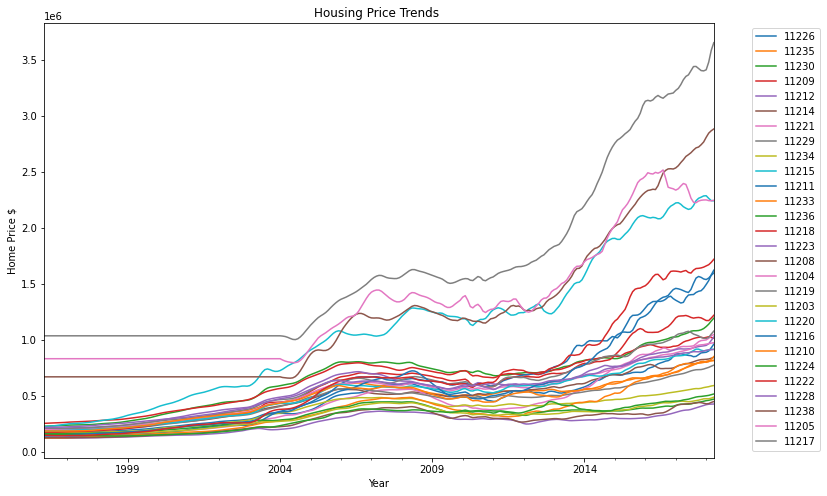

In [20]:
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Baltimore Crime Rates - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Price $')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

In [21]:
year = '2014'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

In [22]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(225, 28)
(52, 28)


In [23]:
zip_df[11220]

Month
1996-04-01    188500.0
1996-05-01    188700.0
1996-06-01    188800.0
1996-07-01    189000.0
1996-08-01    189400.0
                ...   
2017-12-01    903000.0
2018-01-01    906500.0
2018-02-01    910700.0
2018-03-01    915600.0
2018-04-01    917900.0
Freq: MS, Name: 11220, Length: 265, dtype: float64

In [24]:
train_brk[11220]

Month
1996-04-01    188500.0
1996-05-01    188700.0
1996-06-01    188800.0
1996-07-01    189000.0
1996-08-01    189400.0
                ...   
2014-08-01    680000.0
2014-09-01    684100.0
2014-10-01    688300.0
2014-11-01    695400.0
2014-12-01    699600.0
Freq: MS, Name: 11220, Length: 225, dtype: float64

In [25]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [26]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [27]:
#stepwise_fit = auto_arima(train_brk[11220],start_p=0, start_q=0,max_p=6,max_q=3, trace=True)

def arima_model(df):
    autoarima_model = auto_arima(df, start_p = 1, start_q = 1, 
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = 1,               # let model determine 'd'
                              seasonal = True, 
                              start_P=1, D=1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    print('\n')
    display(autoarima_model.summary())
    
    #autoarima_model.plot_diagnostics(figsize=(12,10))
    
    return autoarima_model

    #autoarima_model.summary()

In [28]:
stepwise_fit = arima_model(train_brk[11220])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4327.373, BIC=4347.513, Fit time=3.048 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4341.425, BIC=4348.139, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4417.531, BIC=4430.958, Fit time=0.672 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4315.571, BIC=4328.998, Fit time=0.936 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4276.972, BIC=4293.755, Fit time=2.307 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=4321.820, BIC=4335.246, Fit time=0.373 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4282.564, BIC=4302.703, Fit time=4.269 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4312.603, BIC=4322.673, Fit time=0.259 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4282.622, BIC=4306.118, Fit time=5.282 seconds
Fit ARIMA: order=(0, 1, 0) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  225
Model:             SARIMAX(0, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -2127.646
Date:                            Fri, 06 Nov 2020   AIC                           4269.292
Time:                                    16:11:30   BIC                           4292.788
Sample:                                         0   HQIC                          4278.789
                                            - 225                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     85.9357     60.462      1.421      0.155     -32.567     204.439
ma.L1          0.1707      0.011     15.897      0.000       0.150       0.192
ma.L2          0.1064      0.018      5.823      0.000       0.071       0.142
ma.L3          0.0600      0.039      1.556      0.120      -0.016       0.136
ar.S.L12       0.6425      0.031     20.775      0.000       0.582       0.703
ma.S.L12      -1.0000      0.087    -11.547      0.000      -1.170      -0.830
sigma2       2.73e+07   3.15e-09   8.68e+15      0.000    2.73e+07    2.73e+07
===================================================================================
Ljung-Box (Q):                      297.08   Jarque-Bera (JB):                28.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+36. Standard errors may be unstable.
"""

In [29]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  225
Model:             SARIMAX(0, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -2127.646
Date:                            Fri, 06 Nov 2020   AIC                           4269.292
Time:                                    16:11:30   BIC                           4292.788
Sample:                                         0   HQIC                          4278.789
                                            - 225                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     85.9357     60.462      1.421      0.155     -32.567     204.439
ma.L1          0.1707      0.011     15.897      0.000       0.150       0.192
ma.L2          0.1064      0.018      5.823      0.000       0.071       0.142
ma.L3          0.0600      0.039      1.556      0.120      -0.016       0.136
ar.S.L12       0.6425      0.031     20.775      0.000       0.582       0.703
ma.S.L12      -1.0000      0.087    -11.547      0.000      -1.170      -0.830
sigma2       2.73e+07   3.15e-09   8.68e+15      0.000    2.73e+07    2.73e+07
===================================================================================
Ljung-Box (Q):                      297.08   Jarque-Bera (JB):                28.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+36. Standard errors may be unstable.
"""

In [30]:
#length of test data
future_forecast = stepwise_fit.predict(n_periods=52)
print(future_forecast)

[704378.10870094 710162.41865624 713611.82304689 717350.83104583
 717270.41566033 716943.8461212  718138.62697148 721715.50368646
 726192.01344076 730777.07822044 737339.69891881 741911.65929357
 746605.97631541 751763.5809553  755034.51350744 762032.8195601
 763592.94735586 765005.76850213 767503.90083509 771665.86437858
 776470.22116105 781388.62965877 787691.91447223 792588.79885304
 797315.214601   802156.0904934  805398.28881666 814576.66238364
 817276.79140185 819893.12428649 823314.60878307 827938.43222341
 833039.36974292 838257.89065623 844480.4852774  849672.07232412
 854505.04754953 859228.35775802 862538.02977308 873203.05437468
 876721.58137085 880197.1183789  884297.80165344 889304.31044725
 894681.73979716 900179.02167988 906435.70776366 911902.5799612
 916889.95644592 921623.66524263 925062.6255065  936768.77407801]


<AxesSubplot:xlabel='Month'>

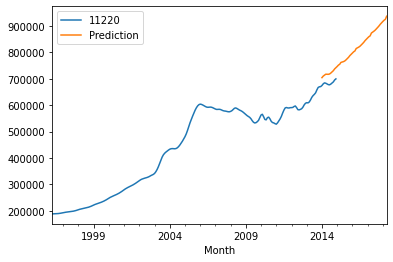

In [31]:
future_forecast = pd.DataFrame(future_forecast,index = test_brk.index,columns=['Prediction'])
pd.concat([train_brk[11220],future_forecast],axis=1).plot()

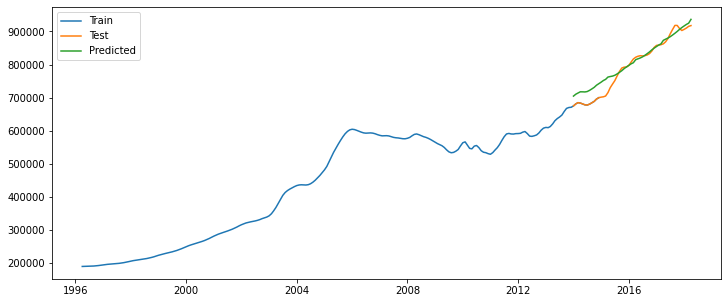

In [32]:
plt.figure(figsize=(12,5))
plt.plot(train_brk[11220], label='Train')
plt.plot(test_brk[11220],label='Test')
plt.plot(future_forecast,label='Predicted')
plt.legend()

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test_brk[11220], future_forecast)
rmse = sqrt(mse)
print(rmse)

24462.197147875693


In [34]:
# kings = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY') &
#                     (all_zipcodes['MeanValue']> 300000.0)]
# kings

In [35]:
#kings['Zipcode'].nunique()

In [36]:
#kings.index

### Zipcode: 11217

In [37]:
#make loop
# brooklyn_zips = {}

# for zipcode in kings['Zipcode'].unique(): 
#     all_zips = kings[kings['Zipcode'] == zipcode]
#     all_zips = all_zips.set_index('Month')['MeanValue']
#     all_zips = all_zips.asfreq('MS')
#     brooklyn_zips[zipcode] = all_zips

<AxesSubplot:xlabel='Month'>

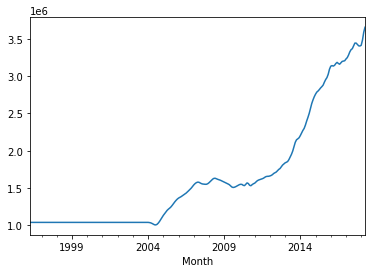

In [38]:
zip_df[11217].plot()

In [39]:
def test_stationarity_1(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()
    

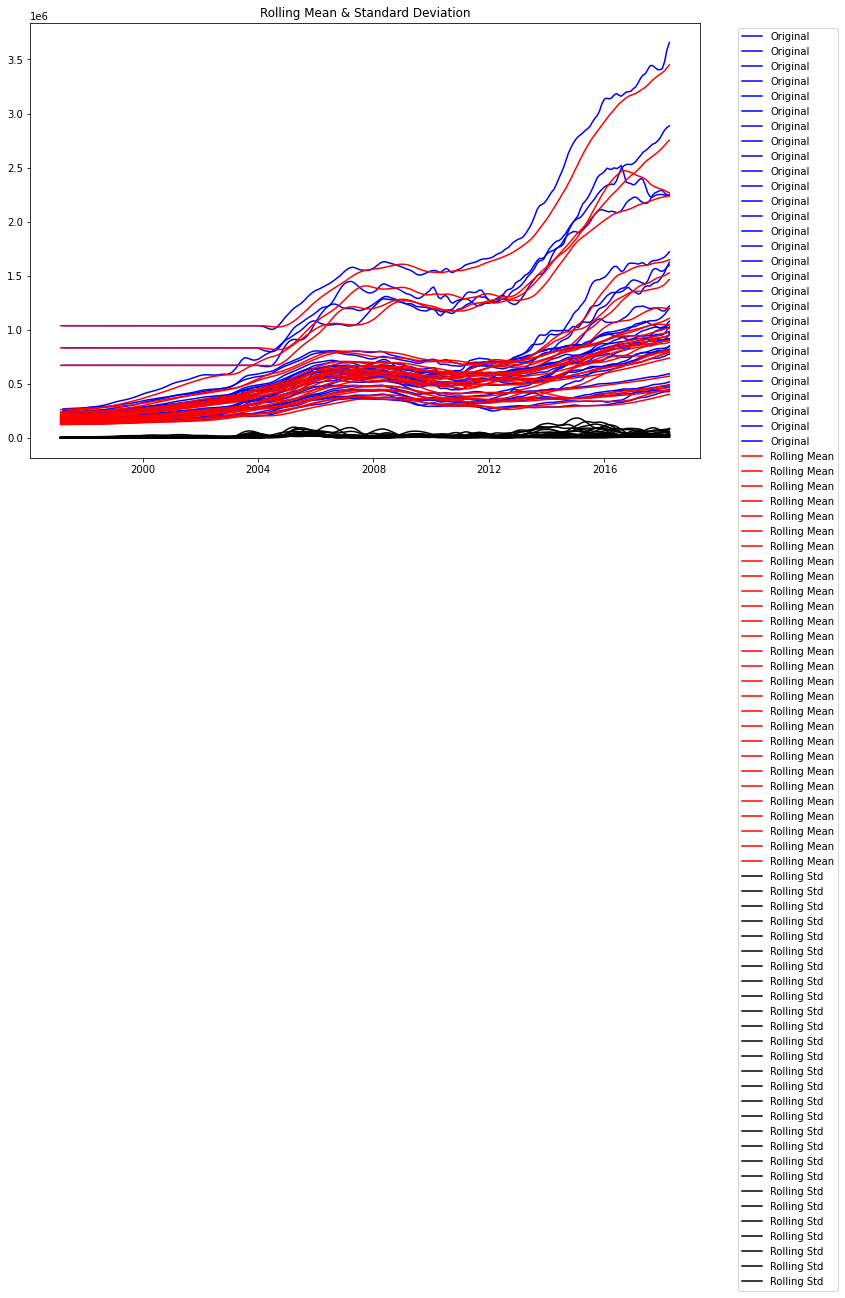

In [40]:
test_stationarity_1(zip_df,12)

In [41]:
#Not mine
# def dickey_fuller_test_ind_zip(zip_code):
#     dftest = adfuller(zip_code)

#     # Extract and display test results in a user friendly manner
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dftest)

#     print ('Results of Dickey-Fuller Test:')

#     print(dfoutput)

In [42]:
def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#         for key,value in dftest[4].items():
#             dfoutput['Critical Value (%s)'%key] = value
        print(dftest)

        print ('Results of Dickey-Fuller Test:')
        print ('\n')
        print(dfoutput)    

In [43]:
dickey_fuller_test_zipcodes(zip_df)

(0.6254102589740157, 0.9882254867110694, 15, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 4684.550681605726)
Results of Dickey-Fuller Test:


Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
dtype: float64
(-0.8284459621478725, 0.8106231633355543, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 4266.968811034178)
Results of Dickey-Fuller Test:


Test Statistic                  -0.828446
p-value                          0.810623
#Lags Used                      16.000000
Number of Observations Used    248.000000
dtype: float64
(0.223603766489784, 0.9735548149047929, 13, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 4500.304053483356)
Results of Dickey-Fuller Test:


Test Statistic                   0.223604
p-value                          0.

(1.3300142358520741, 0.9967718123702427, 13, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 5045.970907033796)
Results of Dickey-Fuller Test:


Test Statistic                   1.330014
p-value                          0.996772
#Lags Used                      13.000000
Number of Observations Used    251.000000
dtype: float64
(-0.4332617846627814, 0.9043953773879375, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 5210.3507755307055)
Results of Dickey-Fuller Test:


Test Statistic                  -0.433262
p-value                          0.904395
#Lags Used                      16.000000
Number of Observations Used    248.000000
dtype: float64
(0.8851083655203256, 0.992892876384823, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 5069.668907952247)
Results of Dickey-Fuller Test:


Test Statistic                   0.885108
p-value                          0.

In [44]:
X_1 = zip_df.copy()

In [46]:
# #stepwise_fit = arima_model(zip_df)

# #history = [x for x in train_brk]
# """
# predictions = []
# for t in range(len(train_brk)):
#     model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
# """

# dict_org = {}
# dict_pred = {}

# for col in X_1:
#     size = int(len(X_1) * 0.70)
#     train, testdata = X_1[0:size], X_1[size:len(X_1)]
#     history = [x for x in train[col]]
#     predictions = list()

#     for column in testdata:
#         model = pm.auto_arima(history, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True) # this works 

#         output = model.predict()

#         yhat = output[0]
#         predictions.append(yhat)
#         obs = testdata[column]
#         history.append(obs)
#         print("Predicted:%f, expected:%f" %(yhat, obs))

#         error = mean_squared_error(testdata, predictions[:len(testdata)])
#     print('Test MSE: %.3f' % error)

#     dict_org.update({X[col]: testdata})
#     dict_pred.update({X[col]: predictions})

#     print("Item: ", X[col], "Test MSE:%f"% error)


In [47]:

dict_org = {}
dict_pred = {}

for col in X_1:
    size = int(len(X_1) * 0.70)
    train, testdata = X_1[0:size], X_1[size:len(X_1)]
    history = [x for x in train[col]]
    predictions = list()


def find_orders(ts):

    stepwise_model = pm.auto_arima(history, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) # this works 

    return stepwise_model.order, stepwise_model.seasonal_order

In [48]:
traindata, testdata = find_orders(X_1)

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=3876.791, BIC=3883.221, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0); AIC=3614.881, BIC=3624.526, Fit time=0.089 seconds
Fit ARIMA: order=(0, 1, 1); AIC=3656.016, BIC=3665.661, Fit time=0.084 seconds
Fit ARIMA: order=(2, 1, 0); AIC=3564.878, BIC=3577.738, Fit time=0.039 seconds
Fit ARIMA: order=(2, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=3481.005, BIC=3497.080, Fit time=0.113 seconds
Total fit time: 0.477 seconds


In [49]:
# for column in testdata:
#         order, seasonal_order = find_orders(ts)
#         fit_arimax(ts, order=order, seasonal_order=seasonal_order)

TypeError: 'NoneType' object is not iterable

In [50]:
"""
history = [x for x in zip_df]
predictions = list()
predict_log=list()
for t in range(len(zip_df)):
    model = sm.tsa.SARIMAX(history,start_p=1, start_q=1,enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = zip_df[t]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (output[0], obs))
"""
history = [x for x in zip_df]
predictions = list()
predict_log=list()
for t in range(len(zip_df)):
    stepwise_model = auto_arima(history, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=180.980, BIC=183.967, Fit time=0.038 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.228 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.12

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.445 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.110 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.437 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=175.119, BIC=179.102, Fit time=0.169 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.217 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.246 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.061 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=18

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.414 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.109 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.194 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.222 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.568 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.195 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.422 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.221 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.246 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.062 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.393 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 3.009 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.109 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.266 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.067 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.149 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.235 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.387 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.118 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.416 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.190 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.243 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.272 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.520 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.252 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.134 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.208 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.338 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.115 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.359 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.191 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.246 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.061 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.281 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.414 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.062 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.207 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.124 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.204 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.371 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.117 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.371 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.192 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.229 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.269 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.477 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.196 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.054 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.140 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.216 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.356 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.105 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.368 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.187 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.252 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.060 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.265 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.674 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.208 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.047 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.135 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.210 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.357 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.109 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.356 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.223 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.266 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.483 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 3.551 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.105 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.186 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.047 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.123 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.225 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.378 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.107 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.349 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.246 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.311 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.492 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.914 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.181 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.225 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.049 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.140 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.224 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.381 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.109 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.367 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.208 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.275 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.079 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.346 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.856 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.287 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.090 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.200 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.203 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.334 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.108 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.362 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.191 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.262 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.064 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.299 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.631 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.077 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.188 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.125 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.204 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.340 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.147 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.446 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.226 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.244 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.279 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.523 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.073 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.185 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.045 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.122 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.211 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.357 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.105 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.355 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.181 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.236 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.274 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.752 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.066 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.204 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.048 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.326 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.205 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.356 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.109 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.355 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.183 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.241 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.266 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.388 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.067 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.190 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.125 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.204 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.332 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.106 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.353 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.189 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.226 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.307 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.470 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.189 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.047 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.128 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.206 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.333 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.106 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.357 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.179 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.229 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.264 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.395 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.191 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.123 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.203 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.335 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.106 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.348 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.182 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.235 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.301 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.418 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.190 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.049 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.136 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.211 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.360 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.105 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.350 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.181 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.231 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.054 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.273 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.702 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.227 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.076 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.139 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.201 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.339 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.107 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.356 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.185 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.315 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.069 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.367 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.591 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.086 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.203 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.047 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.126 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.207 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.342 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.110 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.358 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.185 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.229 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.268 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.384 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.067 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.196 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.047 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.135 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.214 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.384 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.120 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.452 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.186 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.227 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.271 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.501 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.060 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.200 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.052 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.139 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.216 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.337 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.112 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.397 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.194 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.235 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.269 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.606 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.061 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.194 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.047 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.127 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.208 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.337 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.108 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.356 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=175.119, BIC=179.102, Fit time=0.432 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.223 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.285 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.076 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.312 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 3.246 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.194 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.051 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.127 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.212 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.340 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.110 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.510 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=175.119, BIC=179.102, Fit time=0.196 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.194 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.263 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.282 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.882 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.192 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.048 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.126 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.209 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.334 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.112 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.347 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.196 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.259 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.063 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.269 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.499 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.017 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.062 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.188 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.047 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.127 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.208 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.342 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.107 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.354 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.186 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.263 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.275 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.489 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.112 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.231 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.064 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.131 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.251 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.442 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.157 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.396 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=175.119, BIC=179.102, Fit time=0.262 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.224 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.263 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.076 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.291 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 3.051 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.188 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.122 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.206 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.333 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.108 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.349 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.194 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.231 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.273 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.469 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.272 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.058 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.172 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.293 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.371 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.107 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.363 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.176 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.228 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.055 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.259 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.322 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.188 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.124 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.200 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.332 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.106 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.352 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.197 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.313 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.063 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.316 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.524 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.061 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.219 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.048 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.126 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.209 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.339 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.110 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.409 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=175.119, BIC=179.102, Fit time=0.332 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.180 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.233 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.283 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.627 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.302 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.092 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.201 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.201 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.441 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.109 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.450 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.193 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.237 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.267 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.688 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.229 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.051 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.153 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.205 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.357 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.105 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.354 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.181 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.229 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.061 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.275 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.374 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.060 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.196 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.055 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.129 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.211 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.372 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.148 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.458 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.185 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.239 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.397 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.848 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.115 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.197 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.049 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.126 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.205 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.338 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.108 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.664 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.204 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.233 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.267 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.582 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.195 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.047 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.129 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.207 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.680 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.230 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.669 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=175.119, BIC=179.102, Fit time=0.282 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.259 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.232 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.055 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.267 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 3.519 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.287 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.076 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.253 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.329 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.507 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.148 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.440 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.188 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.229 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.271 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.959 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.061 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.225 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.050 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.132 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.329 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.485 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.320 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.364 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.195 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.237 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.268 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.469 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=179.697, BIC=183.680, Fit time=0.059 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7);

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=180.764, BIC=185.743, Fit time=0.387 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.450, BIC=183.437, Fit time=0.087 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=180.103, BIC=185.081, Fit time=0.218 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=176.539, BIC=181.517, Fit time=0.263 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=178.751, BIC=185.721, Fit time=0.556 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.908, BIC=182.891, Fit time=0.184 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=177.696, BIC=183.671, Fit time=0.589 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, F

Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=175.119, BIC=179.102, Fit time=0.271 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.396, BIC=181.375, Fit time=0.280 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 0, 7); AIC=176.767, BIC=182.742, Fit time=0.375 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=178.094, BIC=181.081, Fit time=0.090 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 7); AIC=176.533, BIC=181.512, Fit time=0.407 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 3.031 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=182.488, BIC=184.479, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7);

In [59]:
# X = zip_df
# dict_org = {}
# dict_pred = {}

# for col in X:
#     size = int(len(X) * 0.70)
#     train, testdata = X[0:size], X[size:len(X)]
#     history = [x for x in train[column]]
#     predictions = list()
    
# def find_orders(ts):

#     stepwise_model = pm.auto_arima(history, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True) # this works 

#     return stepwise_model.order, stepwise_model.seasonal_order
# find_orders(zip_df)

# for column in testdata:
#         order, seasonal_order = find_orders(ts)
#         fit_arimax(ts, order=order, seasonal_order=seasonal_order)



#     for column in testdata:
#         model = pm.auto_arima(history, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True) # this works 

#         output = model.predict()

#         yhat = output[0]
#         predictions.append(yhat)
#         predictions.append(yhat)
#         obs = testdata[column]
#         history.append(obs)
#         print("Predicted:%f, expected:%f" %(yhat, obs))

#         error = mean_squared_error(testdata, predictions[:len(testdata)])
#     print('Test MSE: %.3f' % error)

#     dict_org.update({X[col]: testdata})
#     dict_pred.update({X[col]: predictions})

#     print("Item: ", X[col], "Test MSE:%f"% error)
# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     mse = evaluate_arima_model(dataset, order)
#                     if mse < best_score:
#                         best_score, best_cfg = mse, order
#                     print('ARIMA%s MSE=%.3f' % (order,mse))
#                 except:
#                     continue
#     print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

In [ ]:
stationary_test(zip_df[11217])

###  Zipcode:  11238

In [ ]:
#brooklyn_zips[11238]

In [ ]:
stationary_test(zip_df[11238])

### Zipcode:  11215

In [ ]:
stationary_test(zip_df[11215])

### Removing Trend
#### Log-Transformation (np.log)

In [ ]:
## Log Transform
ts3 = np.log(zip_df[11238])
#ts3.plot()
stationary_test(ts3)

#### Differencing

In [ ]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11238].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

In [ ]:
## Subtract Rolling mean
ts2 = (zip_df[11238] - zip_df[11238].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

In [ ]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11238] - zip_df[11238].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

In [ ]:
"""
it will identfies patterns, trends in ts and separate them into 3 new ts.
residual-what was left over after removing all the other components.
"""
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11238])#,model='mul')
decomp.plot();

In [ ]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

In [ ]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

In [ ]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [ ]:
decomp.resid.dropna()

### GridSearch 

#### Find the values of ARIMA(p,d,q)(P,D,Q)s

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#### Identify the set of parameters that will produce the best fitting model to time series dataset.

In [ ]:
"""
(AIC) is an estimator of the relative quality of statistical models for a given set of data. 
Given a collection of models for the data, AIC estimates the quality of each model, relative to each of 
    the other models. AIC provides a means for model selection.

Model that fits the data very well while using lots of features will be assigned a larger AIC score than a model
    that uses fewer features to achieve the same goodness-of-fit. 
    We are interested in finding the model that yields the lowest AIC value. 

"""
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
def gridsearch_pdq(pdq, pdqs, df):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
                
            except:
                continue
    
    
    
    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    #ans_df.loc[ans_df['aic'].idxmin()]

    
    return ans_df           

In [ ]:
gs_pdq = gridsearch_pdq(pdq, pdqs,zip_df[11238])

In [ ]:
gs_pdq.sort_values(by='aic')

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(gs_pdq, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

### Creating a SARIMA TS Model

In [ ]:
"""
Using grid search, we have identified the set of parameters that produces the best fitting model 
    to our time series data. 

coef column above shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.

each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

model diagnostics-The purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.
where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
This is a good indication that the residuals are normally distributed.



# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(brooklyn_zips[11238], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
"""
def fit_ARIMA(df, order=None, seasonal_order=None):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    print(output.summary().tables[1])
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    
    return output

In [ ]:
output_summ = fit_ARIMA(zip_df[11238], order=(1,1,1), seasonal_order=(1,1,1,12))

### Validating the Model

In [ ]:
zip_df[11238].head()

In [ ]:
"""
start by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts

plot the real and forecasted values of the time series to assess how well we did

"""
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
pred_conf = pred.conf_int()

In [ ]:
pred_conf

In [ ]:
# Plot real vs predicted values along with confidence interval

plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [ ]:
"""
check for the accuracy of our forecasts using MSE (Mean Squared Error). 
This will provide us with the average error of our forecasts

An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect 
    accuracy, which would be an ideal
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 = zip_df[11238]['2004':]

# Compute the mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
"""
pred = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()
"""
pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.
plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()


#### Return on Investment

In [ ]:
investment = 40000
rent = 700
loss = 1000  #cost of 1000 per year

def roi(investment, rent, loss):
    """
    return on investment is calcualted by net_profit / investment * 100
    12 = # of months in year 
    investment part doesn't need to be touched investment amount is just capital cost of building
    """
    netprofit = rent * 12 - loss
    ROI = (netprofit / investment) * 100
    print(ROI)
    
#roi(investment, rent, loss) 
#calculated return on investment for these parameters
roi(investment, rent, loss)   